## Lesson 2 RNN

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-beta1


In [2]:
def plot_series(time, series, format = "-", start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope = 0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude = 1, phase = 0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level = 1, seed = None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype = "float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)
# Update with noise
series += noise(time, noise_level, seed = 42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [4]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size = 128, shuffle_buffer = shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
  tf.keras.layers.SimpleRNN(40, return_sequences = True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9)
model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])
history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
8/8 [==============================] - 8s 1s/step - loss: 195.6164 - mae: 196.0720
Epoch 2/100
8/8 [==============================] - 0s 34ms/step - loss: 194.8099 - mae: 195.2815
Epoch 3/100
8/8 [==============================] - 0s 37ms/step - loss: 193.5298 - mae: 194.0093
Epoch 4/100
8/8 [==============================] - 0s 55ms/step - loss: 191.9202 - mae: 192.4067
Epoch 5/100
8/8 [==============================] - 0s 45ms/step - loss: 190.0269 - mae: 190.5205
Epoch 6/100
8/8 [==============================] - 0s 41ms/step - loss: 187.8482 - mae: 188.3494
Epoch 7/100
8/8 [==============================] - 0s 32ms/step - loss: 185.3580 - mae: 185.8679
Epoch 8/100
8/8 [==============================] - 0s 41ms/step - loss: 182.5147 - mae: 183.0343
Epoch 9/100
8/8 [==============================] - 0s 39ms/step - loss: 179.2627 - mae: 179.7936
Epoch 10/100
8/8 [=================

8/8 [==============================] - 0s 50ms/step - loss: 21.9351 - mae: 22.6305
Epoch 84/100
8/8 [==============================] - 0s 48ms/step - loss: 13.7955 - mae: 14.3364
Epoch 85/100
8/8 [==============================] - 0s 37ms/step - loss: 15.4103 - mae: 16.1164
Epoch 86/100
8/8 [==============================] - 0s 42ms/step - loss: 23.6387 - mae: 24.1832
Epoch 87/100
8/8 [==============================] - 0s 36ms/step - loss: 21.7405 - mae: 21.5688
Epoch 88/100
8/8 [==============================] - 0s 40ms/step - loss: 26.4847 - mae: 27.4637
Epoch 89/100
8/8 [==============================] - 0s 43ms/step - loss: 19.9043 - mae: 20.6490
Epoch 90/100
8/8 [==============================] - 0s 45ms/step - loss: 19.5351 - mae: 18.8591
Epoch 91/100
8/8 [==============================] - 0s 47ms/step - loss: 43.0144 - mae: 43.5779
Epoch 92/100
8/8 [==============================] - 0s 42ms/step - loss: 40.4256 - mae: 40.7850
Epoch 93/100
8/8 [==============================] - 0

[1e-08, 0.0001, 0, 30]

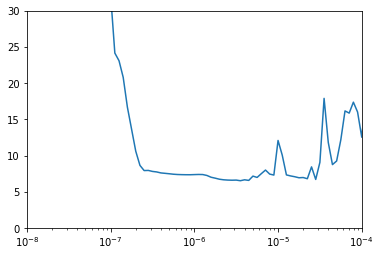

In [5]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size = 128, shuffle_buffer = shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1),
                      input_shape = [None]),
  tf.keras.layers.SimpleRNN(40, return_sequences = True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr = 5e-5, momentum = 0.9)
model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])
history = model.fit(dataset,epochs = 400)

Epoch 1/400
8/8 [==============================] - 6s 797ms/step - loss: 80.8704 - mae: 83.5783
Epoch 2/400
8/8 [==============================] - 0s 28ms/step - loss: 23.3276 - mae: 24.1570
Epoch 3/400
8/8 [==============================] - 0s 40ms/step - loss: 17.8614 - mae: 18.4302
Epoch 4/400
8/8 [==============================] - 0s 46ms/step - loss: 11.9518 - mae: 12.5090
Epoch 5/400
8/8 [==============================] - 0s 46ms/step - loss: 10.1327 - mae: 10.2941
Epoch 6/400
8/8 [==============================] - 0s 46ms/step - loss: 13.7306 - mae: 14.1463
Epoch 7/400
8/8 [==============================] - 0s 39ms/step - loss: 12.3682 - mae: 12.8416
Epoch 8/400
8/8 [==============================] - 0s 45ms/step - loss: 10.8974 - mae: 11.3164
Epoch 9/400
8/8 [==============================] - 0s 42ms/step - loss: 11.3313 - mae: 11.9444
Epoch 10/400
8/8 [==============================] - 0s 43ms/step - loss: 8.4658 - mae: 8.9821
Epoch 11/400
8/8 [==============================] 

Epoch 88/400
8/8 [==============================] - 0s 37ms/step - loss: 4.9703 - mae: 5.4753
Epoch 89/400
8/8 [==============================] - 0s 34ms/step - loss: 5.0028 - mae: 5.5242
Epoch 90/400
8/8 [==============================] - 0s 32ms/step - loss: 4.9858 - mae: 5.4782
Epoch 91/400
8/8 [==============================] - 0s 33ms/step - loss: 5.5212 - mae: 5.9474
Epoch 92/400
8/8 [==============================] - 0s 36ms/step - loss: 5.6842 - mae: 6.1892
Epoch 93/400
8/8 [==============================] - 0s 38ms/step - loss: 5.0917 - mae: 5.5718
Epoch 94/400
8/8 [==============================] - 0s 29ms/step - loss: 4.9494 - mae: 5.4576
Epoch 95/400
8/8 [==============================] - 0s 50ms/step - loss: 5.1180 - mae: 5.5954
Epoch 96/400
8/8 [==============================] - 0s 33ms/step - loss: 5.5332 - mae: 6.0014
Epoch 97/400
8/8 [==============================] - 0s 43ms/step - loss: 5.5325 - mae: 6.0101
Epoch 98/400
8/8 [==============================] - 0s 45ms/

8/8 [==============================] - 0s 30ms/step - loss: 4.5037 - mae: 4.9974
Epoch 175/400
8/8 [==============================] - 0s 45ms/step - loss: 4.7308 - mae: 5.2380
Epoch 176/400
8/8 [==============================] - 0s 30ms/step - loss: 4.4661 - mae: 4.9636
Epoch 177/400
8/8 [==============================] - 0s 37ms/step - loss: 4.6411 - mae: 5.1475
Epoch 178/400
8/8 [==============================] - 0s 41ms/step - loss: 4.7151 - mae: 5.2103
Epoch 179/400
8/8 [==============================] - 0s 45ms/step - loss: 4.8662 - mae: 5.3521
Epoch 180/400
8/8 [==============================] - 0s 41ms/step - loss: 4.7761 - mae: 5.2447
Epoch 181/400
8/8 [==============================] - 0s 32ms/step - loss: 4.8088 - mae: 5.3006
Epoch 182/400
8/8 [==============================] - 0s 40ms/step - loss: 4.5862 - mae: 5.0741
Epoch 183/400
8/8 [==============================] - 0s 33ms/step - loss: 4.6744 - mae: 5.1813
Epoch 184/400
8/8 [==============================] - 0s 40ms/ste

8/8 [==============================] - 0s 40ms/step - loss: 4.9088 - mae: 5.3699
Epoch 261/400
8/8 [==============================] - 0s 35ms/step - loss: 4.4982 - mae: 4.9915
Epoch 262/400
8/8 [==============================] - 0s 34ms/step - loss: 4.6453 - mae: 5.1347
Epoch 263/400
8/8 [==============================] - 0s 40ms/step - loss: 4.5067 - mae: 4.9921
Epoch 264/400
8/8 [==============================] - 0s 34ms/step - loss: 4.5722 - mae: 5.0563
Epoch 265/400
8/8 [==============================] - 0s 43ms/step - loss: 4.4777 - mae: 4.9662
Epoch 266/400
8/8 [==============================] - 0s 39ms/step - loss: 4.5385 - mae: 5.0347
Epoch 267/400
8/8 [==============================] - 0s 51ms/step - loss: 4.4337 - mae: 4.9179
Epoch 268/400
8/8 [==============================] - 0s 39ms/step - loss: 4.6436 - mae: 5.1261
Epoch 269/400
8/8 [==============================] - 0s 42ms/step - loss: 4.4733 - mae: 4.9632
Epoch 270/400
8/8 [==============================] - 0s 44ms/ste

8/8 [==============================] - 0s 51ms/step - loss: 4.4483 - mae: 4.9440
Epoch 347/400
8/8 [==============================] - 0s 46ms/step - loss: 4.4404 - mae: 4.9086
Epoch 348/400
8/8 [==============================] - 0s 42ms/step - loss: 4.4939 - mae: 4.9823
Epoch 349/400
8/8 [==============================] - 0s 53ms/step - loss: 5.0873 - mae: 5.5197
Epoch 350/400
8/8 [==============================] - 0s 42ms/step - loss: 4.4237 - mae: 4.9134
Epoch 351/400
8/8 [==============================] - 0s 37ms/step - loss: 4.5449 - mae: 4.9905
Epoch 352/400
8/8 [==============================] - 0s 34ms/step - loss: 4.3020 - mae: 4.8027
Epoch 353/400
8/8 [==============================] - 0s 48ms/step - loss: 4.2676 - mae: 4.7571
Epoch 354/400
8/8 [==============================] - 0s 39ms/step - loss: 4.4226 - mae: 4.9333
Epoch 355/400
8/8 [==============================] - 0s 33ms/step - loss: 4.6099 - mae: 5.0953
Epoch 356/400
8/8 [==============================] - 0s 45ms/ste

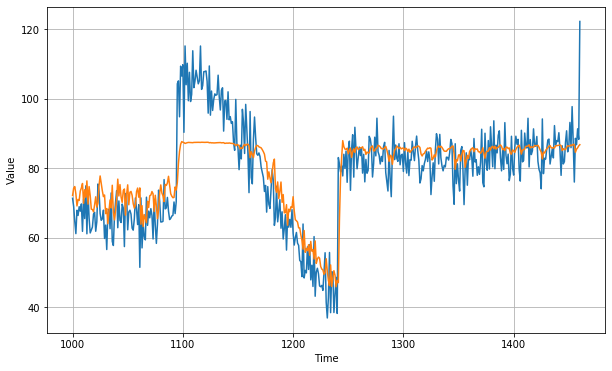

In [7]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize = (10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [8]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.624356

<Figure size 432x288 with 0 Axes>

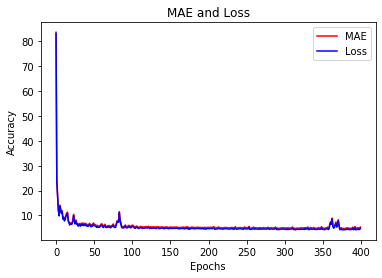

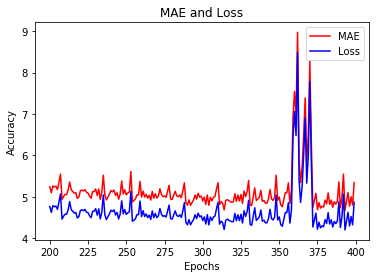

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae = history.history["mae"]
loss = history.history["loss"]

epochs = range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, "r")
plt.plot(epochs, loss, "b")
plt.title("MAE and Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, "r")
plt.plot(epochs_zoom, loss_zoom, "b")
plt.title("MAE and Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

## Lesson 4 LSTM

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9)
model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])
history = model.fit(dataset, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
31/31 [==============================] - 22s 695ms/step - loss: 21.4949 - mae: 22.0115
Epoch 2/100
31/31 [==============================] - 1s 47ms/step - loss: 21.1328 - mae: 21.6472
Epoch 3/100
31/31 [==============================] - 2s 51ms/step - loss: 20.7158 - mae: 21.2292
Epoch 4/100
31/31 [==============================] - 2s 52ms/step - loss: 20.2701 - mae: 20.7798
Epoch 5/100
31/31 [==============================] - 2s 61ms/step - loss: 19.7780 - mae: 20.2896
Epoch 6/100
31/31 [==============================] - 2s 50ms/step - loss: 19.1758 - mae: 19.6838
Epoch 7/100
31/31 [==============================] - 2s 51ms/step - loss: 18.2329 - mae: 18.7455
Epoch 8/100
31/31 [==============================] - 2s 52ms/step - loss: 17.4745 - mae: 17.9816
Epoch 9/100
31/31 [==============================] - 2s 51ms/step - loss: 17.1541 - mae: 17.6597
Epoch 10/100
31/31 [==============================] - 2s 53ms/step - loss: 16.8486 - mae: 17.3525
Epoch 11/100
31/31 [=======

31/31 [==============================] - 2s 58ms/step - loss: 13.5990 - mae: 14.1009
Epoch 23/100
31/31 [==============================] - 2s 58ms/step - loss: 13.3874 - mae: 13.8871
Epoch 24/100
31/31 [==============================] - 2s 55ms/step - loss: 13.1721 - mae: 13.6703
Epoch 25/100
31/31 [==============================] - 2s 60ms/step - loss: 12.9491 - mae: 13.4467
Epoch 26/100
31/31 [==============================] - 2s 60ms/step - loss: 12.7177 - mae: 13.2158
Epoch 27/100
31/31 [==============================] - 2s 73ms/step - loss: 12.4759 - mae: 12.9747
Epoch 28/100
31/31 [==============================] - 2s 54ms/step - loss: 12.2282 - mae: 12.7263
Epoch 29/100
31/31 [==============================] - 2s 53ms/step - loss: 11.9710 - mae: 12.4713
Epoch 30/100
31/31 [==============================] - 2s 57ms/step - loss: 11.7008 - mae: 12.2018
Epoch 31/100
31/31 [==============================] - 2s 54ms/step - loss: 11.3790 - mae: 11.8717
Epoch 32/100
31/31 [=============

[1e-08, 0.0001, 0, 30]

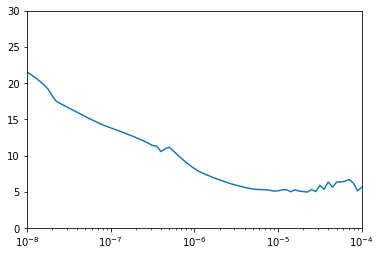

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss = "mse", optimizer = tf.keras.optimizers.SGD(lr = 1e-5, momentum = 0.9),metrics = ["mae"])
history = model.fit(dataset, epochs = 500, verbose = 0)

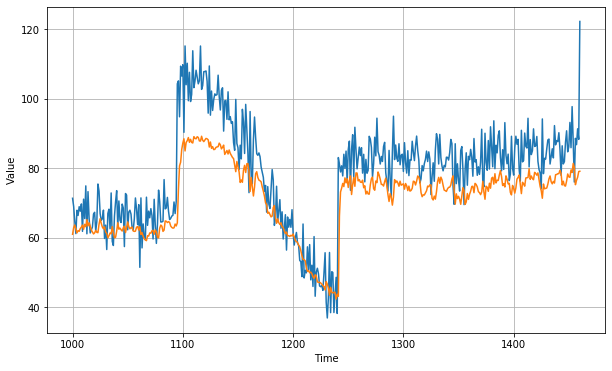

In [13]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize = (10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

8.240746